[View in Colaboratory](https://colab.research.google.com/github/VibhuJawa/variational_autoencoders/blob/master/variationa_auto_encoders_starter_code.ipynb)

### Custom LaTeX commands (do not delete this cell)
$$
\DeclareMathOperator{\softmax}{softmax}
\DeclareMathOperator{\sigmoid}{sigmoid}
\DeclareMathOperator{\softplus}{softplus}
\DeclareMathOperator{\diag}{diag}
\DeclareMathOperator{\Categorical}{Categorical}
\DeclareMathOperator{\Normal}{Normal}
\DeclareMathOperator{\E}{E}
\DeclareMathOperator{\KL}{KL}
\DeclareMathOperator{\ELBO}{ELBO}
\newcommand{\xb}{\boldsymbol{x}}
\newcommand{\zb}{\boldsymbol{z}}
\newcommand{\Ib}{\boldsymbol{I}}
\newcommand{\mub}{\boldsymbol{\mu}}
\newcommand{\sigmab}{\boldsymbol{\sigma}}
\newcommand{\0}{\boldsymbol{0}}
$$

# Variational Autoencoders

In this lab we'll explore unsupervised learning with variational autoencoders. We will learn a compact and meaningful representation of digits.

High level overview, to supplement what we'll go over during the lab:
- We will specify $p(\zb)$, a prior over our latent encoding $\zb$, as a normal distribution with mean $\0$ and covariance $\Ib$.
- We will specify $p(\xb \mid \zb)$, a distribution over an image given a latent encoding, as normal *with a mean that is computed from $\zb$ using a neural network*. This *decoder* network maps $\zb$ to a mean $\mub_x$ and a covariance $\diag(\sigmab_x)$ (which we will assume to be fixed).
- This in turn fully specifies $p(\zb \mid \xb)$, but to obtain it we'd need to marginalize out $\zb$. This is intractable because $p(\xb \mid \zb)$ is complex (it's normal, but remember that its mean is a complex function of $\zb$).
- Thus we will *approximate* $p(\zb \mid \xb)$ with $q(\zb \mid \xb)$, a normal distribution *with a mean and covariance that is computed from $\xb$ using a different neural network*. This *encoder* network maps an image $\xb$ to a mean $\mub_z$ and a covariance $\diag(\sigmab_z)$, which in turn lets us sample $\zb$
- We will train the encoder network and the decoder network jointly to maximize the evidence lower bound (ELBO) of our data. (Perhaps you remember this lower bound from expectation maximization?)
- Finally, we will visualize reconstructions from our encodings, compare them to the original images, and explore $\zb$ space to smoothly interpolate between an image of a 1 and an image of a 7.

In [2]:
# !pip install http://download.pytorch.org/whl/torch-0.1.12.post2-cp27-none-macosx_10_7_x86_64.whl
!pip install torchvision

mkl-random 1.0.1 requires cython, which is not installed.
mkl-fft 1.0.0 requires cython, which is not installed.


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['axes.grid'] = False

import math
import numpy as np
from scipy import stats
import time
import itertools

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision

from pathlib import Path
HOME = Path.home()
MNIST_PATH = HOME / 'data' / 'mnist'

NUM_CLASSES = 10
CHANNELS = 1
HEIGHT = 28
WIDTH = 28

Z_DIM = 16
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_STEPS = 5000

ImportError: No module named 'torch'

In [9]:
# We're going to load the official MNIST train set and use
# *only* the images (not the labels).
official_mnist_train = torchvision.datasets.MNIST(str(MNIST_PATH), train=True, download=True)
train_images = official_mnist_train.train_data.numpy().astype(np.float32)

NameError: name 'torchvision' is not defined

In [5]:
print(train_images.shape)

(60000, 28, 28)


In [0]:
train_images -= train_images.mean(axis=(1, 2), keepdims=True)
train_images /= train_images.std(axis=(1, 2), keepdims=True)

In [7]:
print(train_images[:3].mean(axis=(1, 2)))
print(train_images[:3].std(axis=(1, 2)))

[ 0.0000000e+00 -1.2164214e-08  0.0000000e+00]
[1. 1. 1.]


Let's view a 5 x 5 grid of the first 25 images.

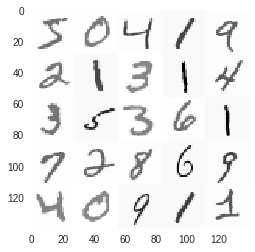

In [8]:
image_grid = train_images[:25].reshape(5, 5, HEIGHT, WIDTH)
image_grid = np.concatenate(image_grid, axis=1)
image_grid = np.concatenate(image_grid, axis=1)
plt.imshow(image_grid)
plt.grid(False)

Let's convert the images to vectors by flattening them, as we have done in the past:

In [0]:
train_vectors = train_images.reshape(-1, HEIGHT * WIDTH)

Now let's define a batch function for retrieving examples (which is a modified version of what you've written in the past):

In [0]:
def batch(batch_size):
  """Create a random batch of examples.
    
  Args:
    batch_size: An integer.
  
  Returns:
    input_batch: A Variable of floats with shape [batch_size, num_features]
  """
  random_ind = np.random.choice(train_vectors.shape[0], size=batch_size, replace=False)
  input_batch = train_vectors[random_ind]
  input_batch = Variable(torch.from_numpy(input_batch).cuda())
  return input_batch

**Modify the following cell to complete the decoder. It should**

1. Map from our low-dimensional $\zb$ to a hidden layer of 128 units
2. Apply a ReLU nonlinearity
3. Map to a hidden layer of 512 hidden units
4. Apply a ReLU nonlinearity
5. Map to $\mub_x$ (which resides in $\mathbb{R}^{784}$)
6. (In addition, we return a fixed $\sigmab_x$, but this is already in place for you.)

In [0]:
class VAEDecoder(torch.nn.Module):

  def __init__(self, z_dim):
    super().__init__()
    self.z_dim = z_dim
    self.fc1 = torch.nn.Linear(128,128) # map from low-dimensional z to a hidden layer of 128 units
    self.relu = torch.nn.functional.relu # apply a ReLU nonlinearity
    self.fc2 = torch.nn.Linear(128,512)
    self.fc3 = torch.nn.Linear(512,784)

  def forward(self, z):
    # TODO
    x = self.relu(self.fc1(z))
    x = self.relu(self.fc2(x))
    mu_x = self.fc3(x)
    sigma_x = Variable(mu_x.data.new(mu_x.shape).fill_(0.1))
    return mu_x, sigma_x

  def log_p_x_given_z(self, mu_x, sigma_x, x):
    dist = torch.distributions.Normal(mu_x, sigma_x)
    return dist.log_prob(x).sum()

**Modify the following cell to complete the encoder. It should**

1. Map from a flattened image $\xb$ to a hidden layer of 512 units
2. Apply a ReLU nonlinearity
3. Map to a hidden layer of 128 units
4. Apply a ReLU nonlinearity
5. Map to $\mub_z$ and $\sigmab_z$. *Remember that the standard deviations must be positive.* Hint: Look up the documentation for `torch.nn.functional.softplus`.

In [0]:
class VAEEncoder(torch.nn.Module):

  def __init__(self, z_dim):
    super().__init__()
    self.z_dim = z_dim
    self.fc1 = torch.nn.Linear(784,512)
    self.relu = torch.nn.functional.relu
    self.fc2 = torch.nn.Linear(512,128)
    self.fc3 = torch.nn.Linear(128,128)
    self.fc4 = torch.nn.Linear(128,128)
    
    self.softplus = torch.nn.Softplus()
    # TODO

  def forward(self, x):
    # TODO
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    mu_z = self.softplus(self.fc3(x))
    sigma_z = self.softplus(self.fc4(x))         
    
    return mu_z, sigma_z

  def rsample(self, mu_z, sigma_z):
    # If we truly sample, we break our (deterministic) computation graph.
    # This is the reparameterization trick: we sample from a standard
    # normal and transform it with mu_z and sigma_z so that we have
    # a well-defined computation graph (on which we can run backprop).
    standard_normal_samples = Variable(mu_z.data.new(mu_z.shape).normal_())
    scaled_samples = sigma_z * standard_normal_samples
    shifted_scaled_samples = scaled_samples + mu_z
    return shifted_scaled_samples

  def kl(self, mu_z, sigma_z):
    # This is the KL divergence KL( N(mu_z, diag(sigma_z)) || N(0, I) ) in closed form.
    # (It's not difficult to derive; try it!)
    kl_q_z_p_z = 0.5 * torch.sum(-2*torch.log(sigma_z) - 1 + sigma_z**2 + mu_z.pow(2))
    return kl_q_z_p_z

We'll proceed as normal, creating our models and our optimizer...

In [0]:
encoder = VAEEncoder(Z_DIM).cuda()
decoder = VAEDecoder(Z_DIM).cuda()

In [0]:
params = list(itertools.chain(encoder.parameters(), decoder.parameters()))
optimizer = torch.optim.Adam(params, LEARNING_RATE)

And now we'll define our main training step, which aims to maximize the following objective function (actually we'll minimize its negation):

$$
\begin{align*}
\ELBO &\equiv \E_q \log p(\zb, \xb) - \E_q \log q(\zb \mid \xb) \\
      &= \E_q \log p(\zb) + \E_q \log p(\xb \mid \zb) - \E_q \log q(\zb \mid \xb) \\
      &= \E_q \log p(\xb \mid \zb) - \KL( q(\zb \mid \xb) \mid\mid p(\zb))
\end{align*}
$$

For each entry in our batch, we'll estimate the term on the left using a single sample (so the expectation disappears), and we'll obtain the term on the right in closed form (which can be done because both $q$ and $p$ are normal).

In [0]:
def train(samples):
  mu_z, sigma_z = encoder(samples)
  z = encoder.rsample(mu_z, sigma_z)
  mu_x, sigma_x = decoder(z)
  neg_log_p_given_x = -decoder.log_p_x_given_z(mu_x, sigma_x, samples) / samples.shape[0]
  kl = encoder.kl(mu_z, sigma_z) / samples.shape[0]
  loss = neg_log_p_given_x + kl
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return neg_log_p_given_x.data[0], kl.data[0], loss.data[0]

Finally we can train; we'll keep track of the two components of our loss, their sum, and the ratio of the KL term to the log-prob term.

In [0]:
loss_list = []

Step 00000 / 05000. Loss: 38360.35.
Step 00250 / 05000. Loss: 10536.93.
Step 00500 / 05000. Loss: 7153.66.
Step 00750 / 05000. Loss: 5899.77.
Step 01000 / 05000. Loss: 5025.40.
Step 01250 / 05000. Loss: 4685.11.
Step 01500 / 05000. Loss: 3923.60.
Step 01750 / 05000. Loss: 3699.21.
Step 02000 / 05000. Loss: 3692.67.
Step 02250 / 05000. Loss: 3601.83.
Step 02500 / 05000. Loss: 3400.84.
Step 02750 / 05000. Loss: 3353.40.
Step 03000 / 05000. Loss: 3348.25.
Step 03250 / 05000. Loss: 2849.31.
Step 03500 / 05000. Loss: 2971.03.
Step 03750 / 05000. Loss: 3154.24.
Step 04000 / 05000. Loss: 2872.73.
Step 04250 / 05000. Loss: 2953.50.
Step 04500 / 05000. Loss: 2587.10.
Step 04750 / 05000. Loss: 2507.28.


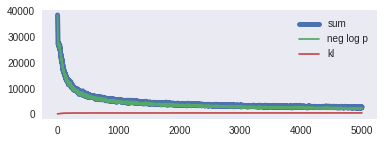

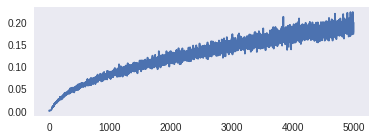

In [60]:
for step in range(NUM_STEPS):
  samples = batch(BATCH_SIZE)
  loss_list.append(train(samples))
  if step % 250 == 0:
    loss = loss_list[-1][2]
    print(f'Step {step:05d} / {NUM_STEPS:05d}. Loss: {loss:.2f}.')

neg_log_p, kl, loss = zip(*loss_list)
plt.figure(figsize=(6, 2))
plt.plot(loss, linewidth=5, label='sum')
plt.plot(neg_log_p, label='neg log p')
plt.plot(kl, label='kl')
plt.legend()

plt.figure(figsize=(6, 2))
plt.plot(np.array(kl) / np.array(neg_log_p))

Now's take a look at some reconstructions: we'll compare the input images ($\xb$) to their reconstructed means ($\mub_x$), computed from samples of $\zb$ from $p(\zb \mid \xb)$.

**Run the following cell repeatedly until you see at least one image of a 1 and one image of a 7.**

Note: If the reconstructions are garbage, e.g. if they look like noise, then you have some debugging to do.

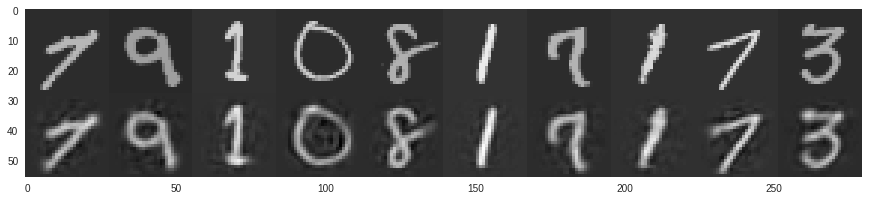

In [65]:
samples = batch(10)

mu_z, sigma_z = encoder(samples)
z = encoder.rsample(mu_z, sigma_z)
mu_x, sigma_x = decoder(z)

samples = samples.view(-1, HEIGHT, WIDTH).data.cpu().numpy()
samples = np.concatenate(samples, axis=1)
mu_x = mu_x.view(-1, HEIGHT, WIDTH).data.cpu().numpy()
mu_x = np.concatenate(mu_x, axis=1)
plt.figure(figsize=(15, 5))
plt.set_cmap('gray')
plt.imshow(np.concatenate([samples, mu_x], axis=0))

**Modify the following cell to visualize generated images as we traverse $\zb$ space from an image to a 1 to an image of a 7. (You should concatenate the images produced by your interpolated $\zb$'s by concatenating their corresponding images horizontally.)**




588


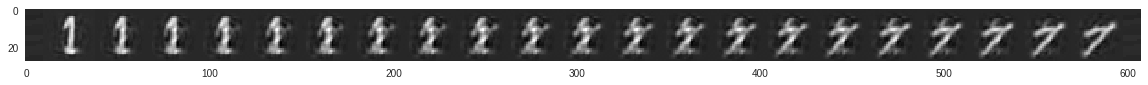

In [127]:
z_1 = z[2] 
z_7 = z[0] # TODO
mixture_coefs = Variable(torch.arange(0.0, 1.0, 0.05).cuda()).view(-1, 1)
z_interp = (1.0 - mixture_coefs)**.5 * z_1 + mixture_coefs**.5 * z_7

mu_x,sigma_x = decoder(z_interp)
mu_x = mu_x.view(-1, HEIGHT, WIDTH).data.cpu().numpy()
mu_x = np.concatenate(mu_x, axis=1)

plt.figure(figsize=(20, 20))
plt.set_cmap('gray')
print(len(mu_x[0]))
output_image = np.concatenate((samples[2].reshape((28,-1)), mu_x,samples[0].reshape((28,-1))), axis = 1)
plt.imshow(output_image)

In [117]:
mu_x.shape

(28, 588)